In [1]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, lit, min, max, mean, stddev
from pyspark.sql.functions import monotonically_increasing_id

from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC

from ucimlrepo import fetch_ucirepo 
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"


/Users/start/opt/anaconda3/envs/spark/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## **1.Data Undestanding**

#### 1.1 Dataset Overview

In [2]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 
  
# metadata 
# print(cdc_diabetes_health_indicators.metadata) 
  
# variable information 
# print(cdc_diabetes_health_indicators.variables) 


In [3]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CDC Diabetes Health Indicators") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
# Converting a pandas DataFrame to a PySpark DataFrame
# X is the feature, y is the target variable
X_pyspark = spark.createDataFrame(X)
y_pyspark = spark.createDataFrame(y)

# Showing the Architecture of a PySpark DataFrame
X_pyspark.printSchema()
y_pyspark.printSchema()

24/10/09 12:11:15 WARN Utils: Your hostname, Mortals-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.2 instead (on interface en0)
24/10/09 12:11:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/09 12:11:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- HighBP: long (nullable = true)
 |-- HighChol: long (nullable = true)
 |-- CholCheck: long (nullable = true)
 |-- BMI: long (nullable = true)
 |-- Smoker: long (nullable = true)
 |-- Stroke: long (nullable = true)
 |-- HeartDiseaseorAttack: long (nullable = true)
 |-- PhysActivity: long (nullable = true)
 |-- Fruits: long (nullable = true)
 |-- Veggies: long (nullable = true)
 |-- HvyAlcoholConsump: long (nullable = true)
 |-- AnyHealthcare: long (nullable = true)
 |-- NoDocbcCost: long (nullable = true)
 |-- GenHlth: long (nullable = true)
 |-- MentHlth: long (nullable = true)
 |-- PhysHlth: long (nullable = true)
 |-- DiffWalk: long (nullable = true)
 |-- Sex: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Education: long (nullable = true)
 |-- Income: long (nullable = true)

root
 |-- Diabetes_binary: long (nullable = true)



In [4]:
ps_x = X_pyspark.pandas_api()
ps_y = y_pyspark.pandas_api()

In [5]:
ps_x.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [6]:
ps_y.describe()

,Diabetes_binary
count,253680.000000
mean,0.139333
std,0.346294
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


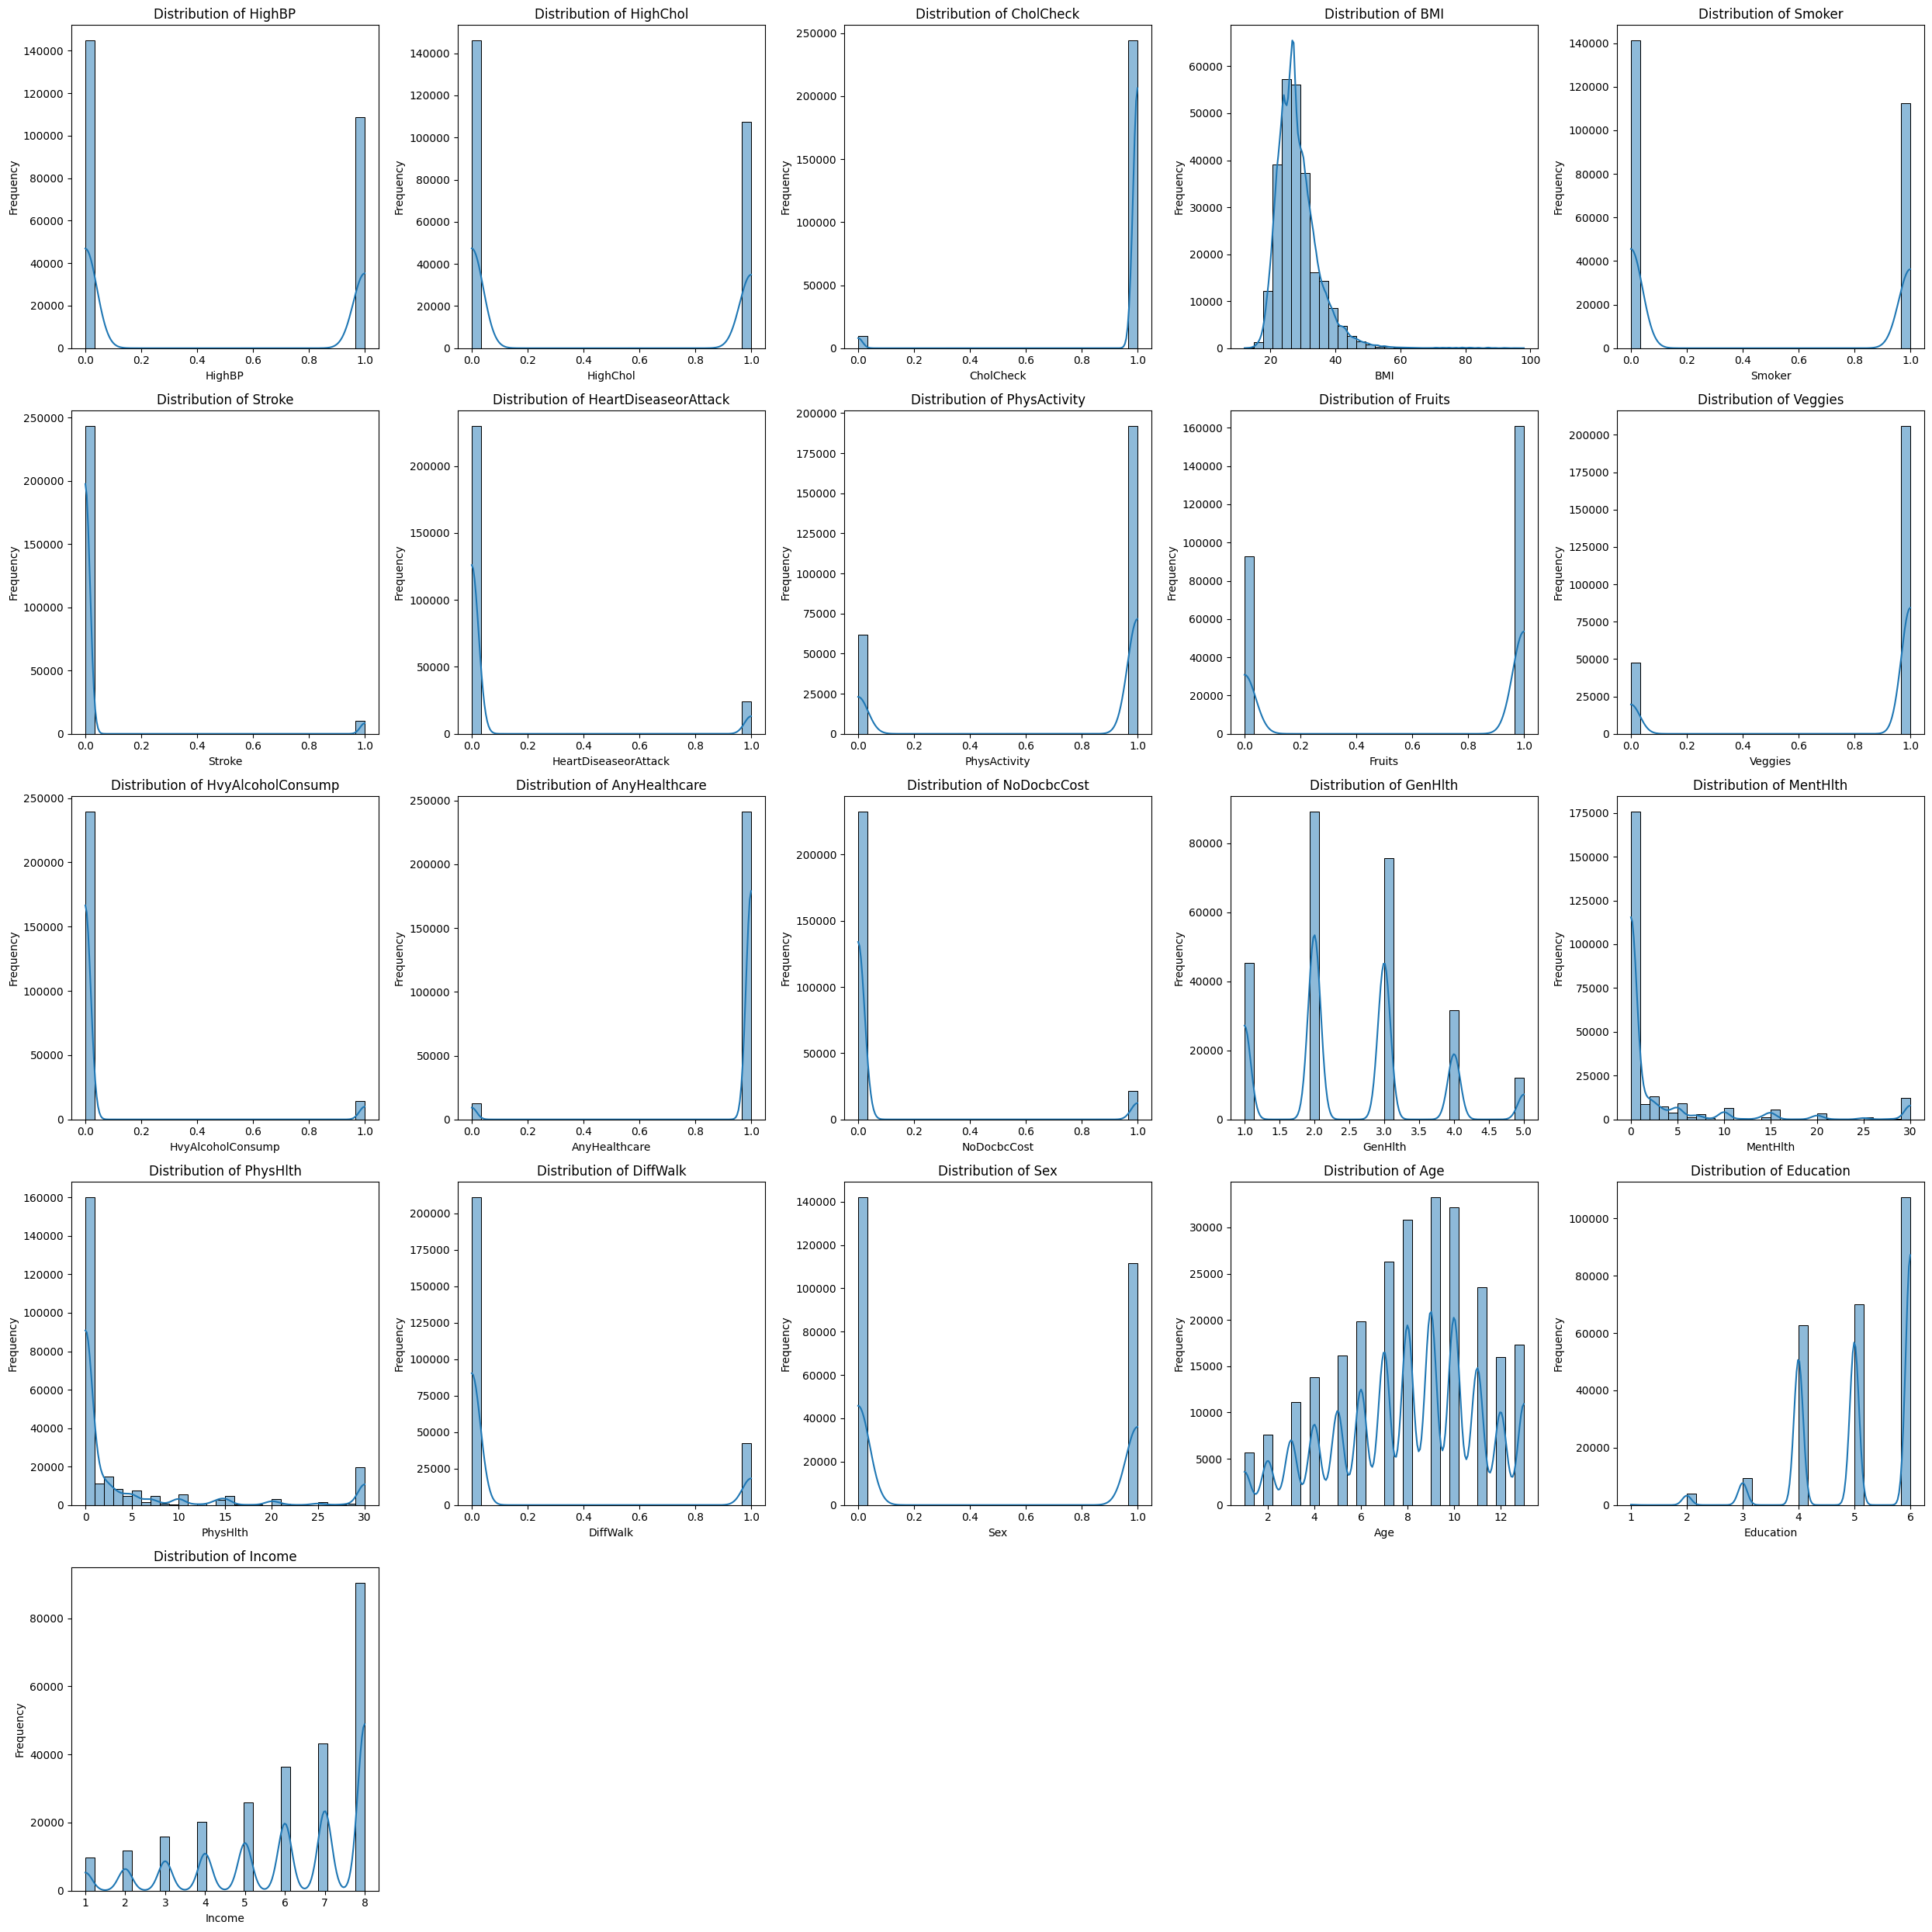

In [7]:
# Get the number of columns
num_columns = len(X_pyspark.columns)
num_rows = (num_columns // 5) + (1 if num_columns % 5 != 0 else 0)

# Create a 5x5 subgraph layout
fig, axes = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows))
axes = axes.flatten()

# Iterate through each column and compute the distribution data, which is then plotted in the subplot
for i, column in enumerate(X_pyspark.columns):
    # Use Spark to select the column and collect the data
    column_data = X_pyspark.select(column).rdd.flatMap(lambda x: x).collect()
    
    # Plotting histograms in the corresponding subplots
    sns.histplot(column_data, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove redundant subgraphs (if there are blank subgraphs)
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout to avoid overlapping subgraphs
plt.tight_layout()

## **2.Data Preprocessing**

#### 2.1 Validity Check

In [8]:
# Define validity checks using a list of conditions
validity_checks = [
    ("HighBP", lambda c: (c == 0) | (c == 1)),
    ("HighChol", lambda c: (c == 0) | (c == 1)),
    ("CholCheck", lambda c: (c == 0) | (c == 1)),
    # ("BMI", lambda c: (c >= 10) & (c <= 80)),  # Example reasonable range
    ("Smoker", lambda c: (c == 0) | (c == 1)),
    ("Stroke", lambda c: (c == 0) | (c == 1)),
    ("HeartDiseaseorAttack", lambda c: (c == 0) | (c == 1)),
    ("PhysActivity", lambda c: (c == 0) | (c == 1)),
    ("Fruits", lambda c: (c == 0) | (c == 1)),
    ("Veggies", lambda c: (c == 0) | (c == 1)),
    ("HvyAlcoholConsump", lambda c: (c == 0) | (c == 1)),
    ("AnyHealthcare", lambda c: (c == 0) | (c == 1)),
    ("NoDocbcCost", lambda c: (c == 0) | (c == 1)),
    ("GenHlth", lambda c: (c >= 1) & (c <= 5)),
    ("MentHlth", lambda c: (c >= 0) & (c <= 30)),
    ("PhysHlth", lambda c: (c >= 0) & (c <= 30)),
    ("DiffWalk", lambda c: (c == 0) | (c == 1)),
    ("Sex", lambda c: (c == 0) | (c == 1)),
    ("Age", lambda c: (c >= 1) & (c <= 13)),
    ("Education", lambda c: (c >= 1) & (c <= 6)),
    ("Income", lambda c: (c >= 1) & (c <= 8))
]

for column_name, validity_check in validity_checks:
    # Filter rows that do not meet the validity check and count them
    invalid_count = X_pyspark.filter(~validity_check(col(column_name))).count()
    print(f"Feature '{column_name}' has {invalid_count} invalid entries.")


Feature 'HighBP' has 0 invalid entries.
Feature 'HighChol' has 0 invalid entries.
Feature 'CholCheck' has 0 invalid entries.
Feature 'Smoker' has 0 invalid entries.
Feature 'Stroke' has 0 invalid entries.
Feature 'HeartDiseaseorAttack' has 0 invalid entries.
Feature 'PhysActivity' has 0 invalid entries.
Feature 'Fruits' has 0 invalid entries.
Feature 'Veggies' has 0 invalid entries.
Feature 'HvyAlcoholConsump' has 0 invalid entries.
Feature 'AnyHealthcare' has 0 invalid entries.
Feature 'NoDocbcCost' has 0 invalid entries.
Feature 'GenHlth' has 0 invalid entries.
Feature 'MentHlth' has 0 invalid entries.
Feature 'PhysHlth' has 0 invalid entries.
Feature 'DiffWalk' has 0 invalid entries.
Feature 'Sex' has 0 invalid entries.
Feature 'Age' has 0 invalid entries.
Feature 'Education' has 0 invalid entries.
Feature 'Income' has 0 invalid entries.


#### 2.2.Features Understanding(aggregation index)

In [9]:
# Summing Fruits and Veggies to indicate the healthiness of a diet
# Summing HighChol and HighBP to indicate overall cardiovascular risk
# Summing Smoker and HvyAlcoholConsump to indicate healthcare accessibility

X_pyspark = X_pyspark.withColumn('Diet', F.col('Fruits') + F.col('Veggies'))

X_pyspark = X_pyspark.withColumn('cardiovascular', F.col('HighChol')  + F.col('HighBP'))

X_pyspark = X_pyspark.withColumn('unhealthy_behavior', F.col('Smoker') + F.col('HvyAlcoholConsump'))

In [10]:
# 0：no healthcare and with cost problem。
# 1：no healthcare and no cost problem。
# 2：with healthcare but with cost problem。
# 3：with healthcare and no cost problem。

X_pyspark = X_pyspark.withColumn('healthcare',
    F.when((F.col('AnyHealthcare') == 1) & (F.col('NoDocbcCost') == 0), 3)
     .when((F.col('AnyHealthcare') == 1) & (F.col('NoDocbcCost') == 1), 2)
     .when((F.col('AnyHealthcare') == 0) & (F.col('NoDocbcCost') == 0), 1)
     .when((F.col('AnyHealthcare') == 0) & (F.col('NoDocbcCost') == 1), 0)
     .otherwise(-1))


#### 2.3 Data Transformation

In [11]:
# Min-Max Scaling: GenHlth, Age, Education, Income, BMI, MentHlth, PhysHlth, Diet, cardiovascular, unhealthy_behavior, healthcare
min_max_features = ["GenHlth", "Age", "Education", "Income", "BMI", "MentHlth", "PhysHlth", "Diet", "cardiovascular", "unhealthy_behavior", "healthcare"]

for feature in min_max_features:
    min_val = X_pyspark.agg(min(col(feature))).collect()[0][0]
    max_val = X_pyspark.agg(max(col(feature))).collect()[0][0]
    X_pyspark = X_pyspark.withColumn(
        feature,
        (col(feature) - min_val) / (max_val - min_val)
    )

# Standardization: BMI, MentHlth, PhysHlth
# standardize_features = ["BMI", "MentHlth", "PhysHlth"]

# for feature in standardize_features:
#     mean_val = X_pyspark.agg(mean(col(feature))).collect()[0][0]
#     stddev_val = X_pyspark.agg(stddev(col(feature))).collect()[0][0]
#     X_pyspark = X_pyspark.withColumn(
#         feature,
#         (col(feature) - mean_val) / stddev_val
#     )


In [12]:
X_pyspark.show(5)

+------+--------+---------+-------------------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+------------------+---------+-------------------+----+--------------+------------------+------------------+
|HighBP|HighChol|CholCheck|                BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|               Age|Education|             Income|Diet|cardiovascular|unhealthy_behavior|        healthcare|
+------+--------+---------+-------------------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+------------------+---------+-------------------+----+--------------+------------------+------------------+
|     1|       1|        1|0.32558139534883723|     1|     0|                   0|           0|  

#### 2.4 Class Imbalance

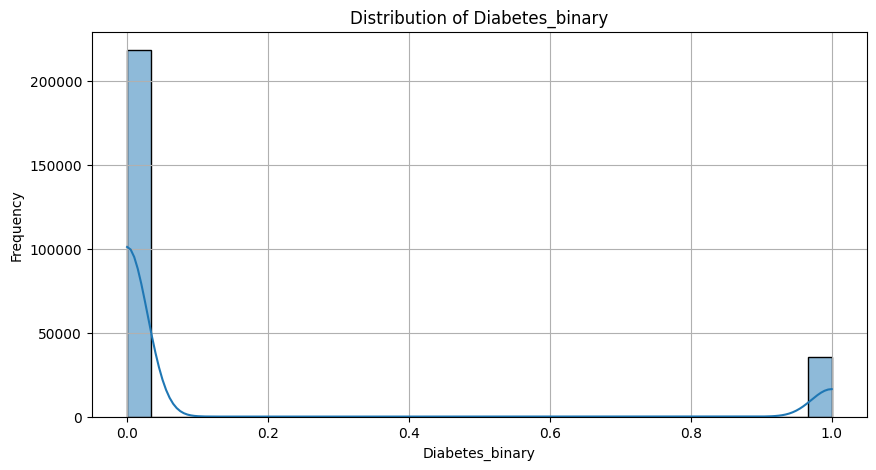

In [13]:
# Iterate through each column and compute the histogram data
for column in y_pyspark.columns:
    # Use the select and rdd methods of the Spark DataFrame to get the data for this column
    column_data = y_pyspark.select(column).rdd.flatMap(lambda x: x).collect()
    
    # Plot the histogram of the column
    plt.figure(figsize=(10, 5))
    sns.histplot(column_data, kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## **3.Exploratory Data Analysis (EDA)**

#### 3.1 Descriptive Statistics

In [14]:
# Convert back to pandas-on-Spark DataFrame
ps_x = X_pyspark.pandas_api()

ps_x.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diet,cardiovascular,unhealthy_behavior,healthcare
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,0.190493,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,0.377848,0.106159,0.141403,0.168224,0.440342,0.586010,0.810087,0.721982,0.722838,0.426561,0.249683,0.939309
std,0.494934,0.494210,0.189571,0.076845,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,0.267119,0.247095,0.290598,0.374066,0.496429,0.254518,0.197155,0.295878,0.346711,0.398461,0.284192,0.188273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.139535,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.416667,0.600000,0.571429,0.500000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.174419,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.583333,0.800000,0.857143,1.000000,0.500000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,0.220930,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.500000,0.066667,0.100000,0.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Plotting the distribution of all indicators

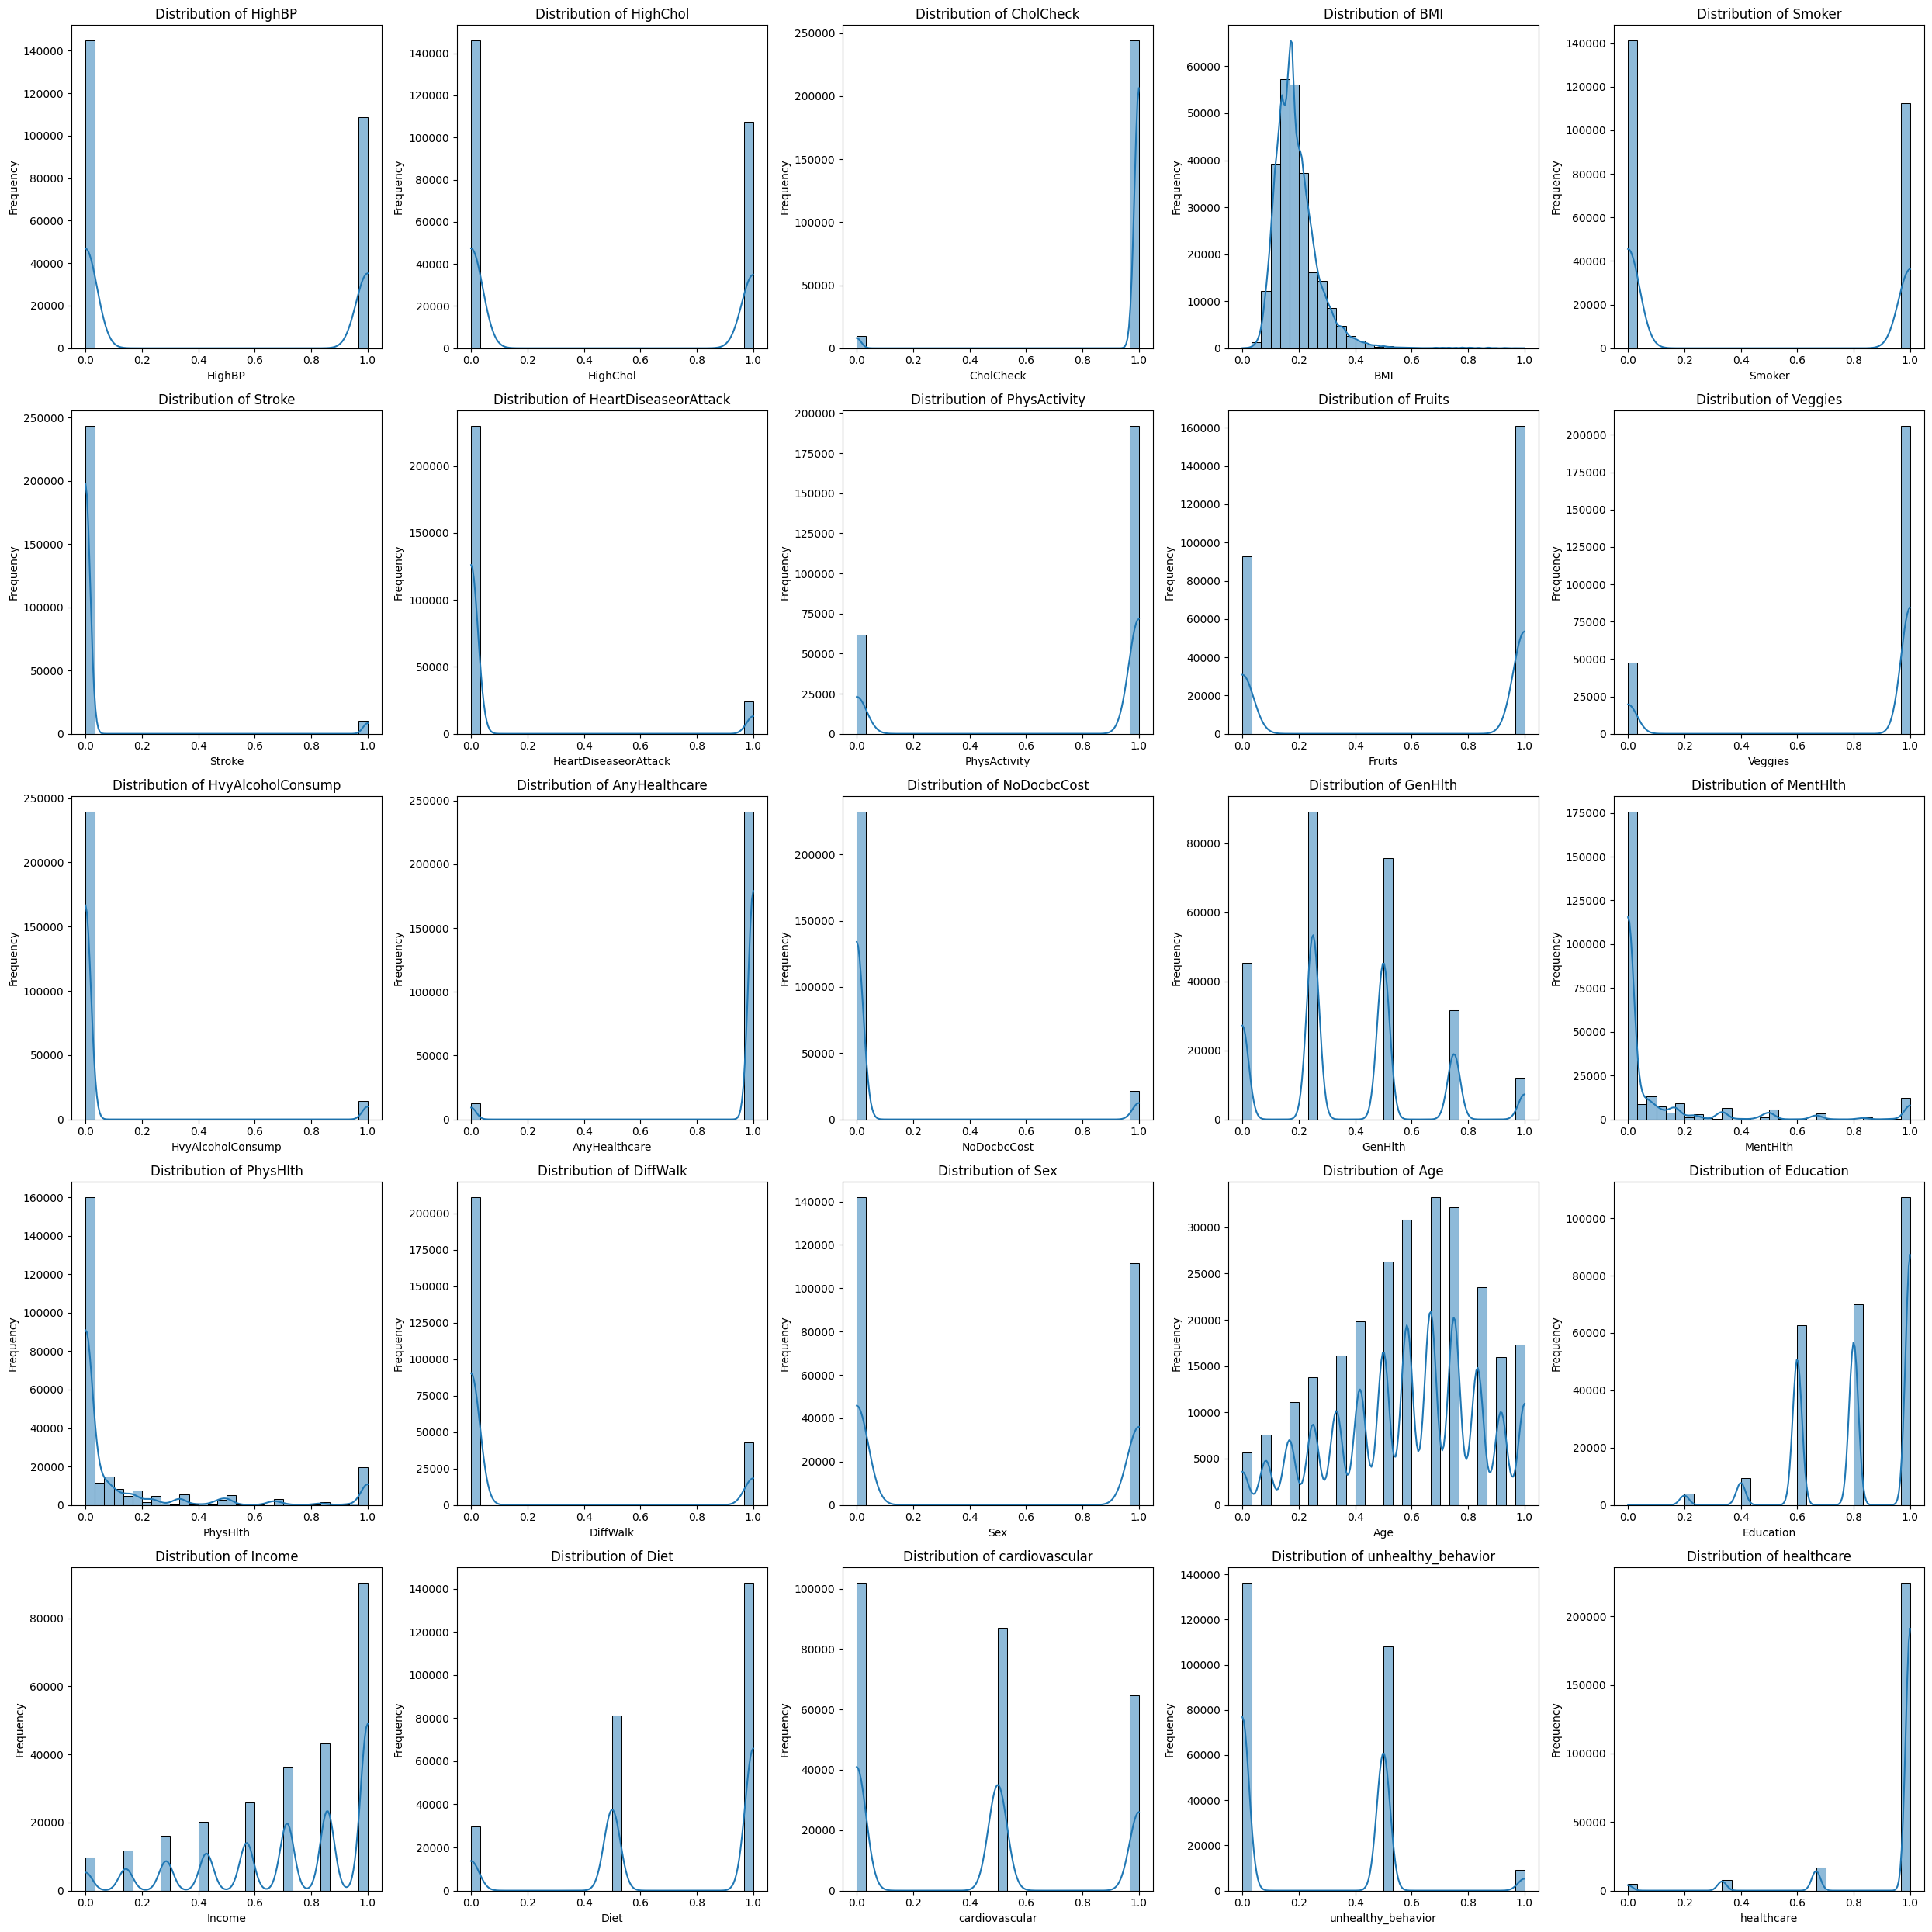

In [15]:
# Get the number of columns
num_columns = len(X_pyspark.columns)
num_rows = (num_columns // 5) + (1 if num_columns % 5 != 0 else 0)

# Create a 5x5 subgraph layout
fig, axes = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows))
axes = axes.flatten()

# Iterate through each column and compute the distribution data, which is then plotted in the subplot
for i, column in enumerate(X_pyspark.columns):
    # Use Spark to select the column and collect the data
    column_data = X_pyspark.select(column).rdd.flatMap(lambda x: x).collect()
    
    # Plotting histograms in the corresponding subplots
    sns.histplot(column_data, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove redundant subgraphs (if there are blank subgraphs)
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout to avoid overlapping subgraphs
plt.tight_layout()

#### 3.2 Correlation Analysis

In [16]:
# Add a unique index column to both DataFrames to ensure row-wise splicing
X_with_id = X_pyspark.withColumn("id", monotonically_increasing_id())
y_with_id = y_pyspark.withColumn("id", monotonically_increasing_id())

# Splice features and targets together, matching by 'id' columns
joined_df = X_with_id.join(y_with_id, on='id', how='inner')

# Remove the 'id' column
joined_df = joined_df.drop('id')

In [17]:
joined_df.show(5)

+------+--------+---------+-------------------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+------------------+-------------------+--------+---+------------------+---------+-------------------+----+--------------+------------------+------------------+---------------+
|HighBP|HighChol|CholCheck|                BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|          MentHlth|           PhysHlth|DiffWalk|Sex|               Age|Education|             Income|Diet|cardiovascular|unhealthy_behavior|        healthcare|Diabetes_binary|
+------+--------+---------+-------------------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+------------------+-------------------+--------+---+------------------+---------+-------------------+----+--------------+------------------+------------------+---

In [18]:
# Combine numerical features into a vector column using VectorAssembler
vector_col = "features"
assembler = VectorAssembler(inputCols=joined_df.columns, outputCol=vector_col)
df_vector = assembler.transform(joined_df).select(vector_col)

In [19]:
df_vector

DataFrame[features: vector]

In [20]:
# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, vector_col, "spearman").head()[0]

# Converting DenseMatrix to a NumPy array and then to a Python list
correlation_array = correlation_matrix.toArray().tolist()

# Creating an RDD and converting it to a Spark DataFrame
correlation_rdd = spark.sparkContext.parallelize(correlation_array)
correlation_df = correlation_rdd.toDF(joined_df.columns)

# Show correlation matrix
correlation_df.show(truncate=False)


+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|HighBP                |HighChol             |CholCheck            |BMI                  |Smoker               |Stroke               |HeartDiseaseorAttack |PhysActivity         |Fruits               |Veggies              |HvyAlcoholConsump     |AnyHealthcare        |NoDocbcCost          |GenHlth              |MentHlth             |PhysHlth            |DiffWalk             |Sex                  |Age                  |Educat

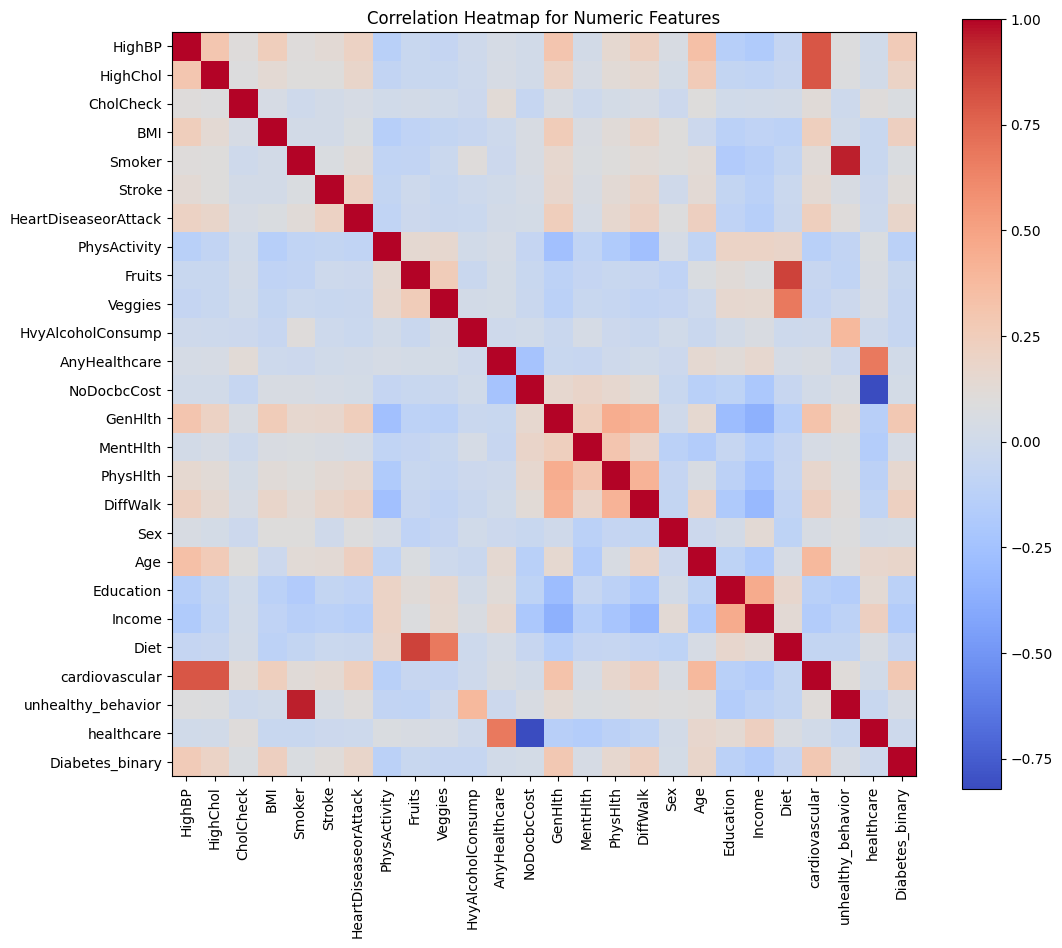

In [21]:
# Collecting data from a Spark DataFrame to a local list
correlation_data = correlation_df.collect()

# Converting Row Objects to 2D Lists
correlation_values = [list(row) for row in correlation_data]

# Heat mapping of correlations
plt.figure(figsize=(12, 10))
plt.imshow(correlation_values, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# Setting the scale and labels for the x and y axes
plt.xticks(ticks=range(len(joined_df.columns)), labels=joined_df.columns, rotation=90)
plt.yticks(ticks=range(len(joined_df.columns)), labels=joined_df.columns)
plt.title('Correlation Heatmap for Numeric Features')

# Show Heat Map
plt.show()

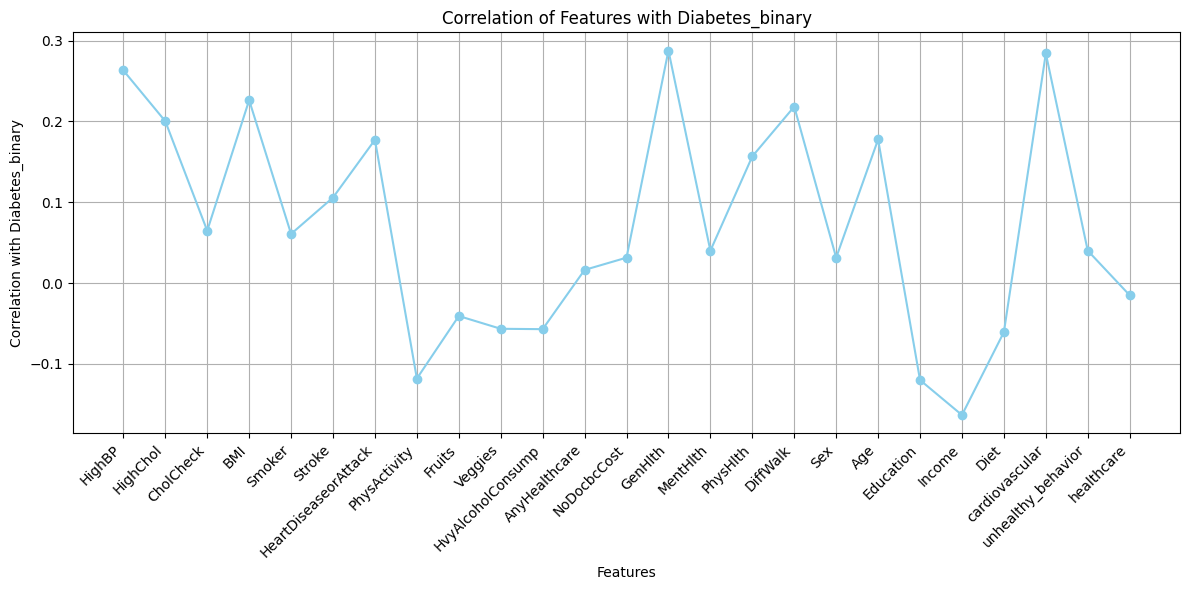

In [22]:
# Extract correlation data from Diabetes_binary column (last column)
diabetes_corr = [row['Diabetes_binary'] for row in correlation_data]

# Extracting other feature names as transverse labels
features = [col for col in joined_df.columns if col != 'Diabetes_binary']

# Plotting line graphs
plt.figure(figsize=(12, 6))
plt.plot(features, diabetes_corr[:-1], marker='o', linestyle='-', color='skyblue')  # Excluding the last item (Diabetes_binary's own correlation with itself)

# Setting up chart labels
plt.xlabel('Features')
plt.ylabel('Correlation with Diabetes_binary')
plt.title('Correlation of Features with Diabetes_binary')
plt.xticks(rotation=45, ha='right')  
plt.grid(True)

# Show Chart
plt.tight_layout()
plt.show()

#### 3.3 Bivariate Analysis

In [23]:
# Extract the index of the Diabetes_binary column
diabetes_idx = correlation_df.columns.index('Diabetes_binary')

# Get feature names with Diabetes_binary correlation greater than 0.2
selected_columns = [
    correlation_df.columns[i] for i in range(len(correlation_df.columns))
    if correlation_data[i][diabetes_idx] > 0.2 and correlation_df.columns[i] != 'Diabetes_binary'
]

# Print correlation indicators greater than 0.2
print("Features with correlation greater than 0.2 with Diabetes_binary:")
print(selected_columns)

Features with correlation greater than 0.2 with Diabetes_binary:
['HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk', 'cardiovascular']


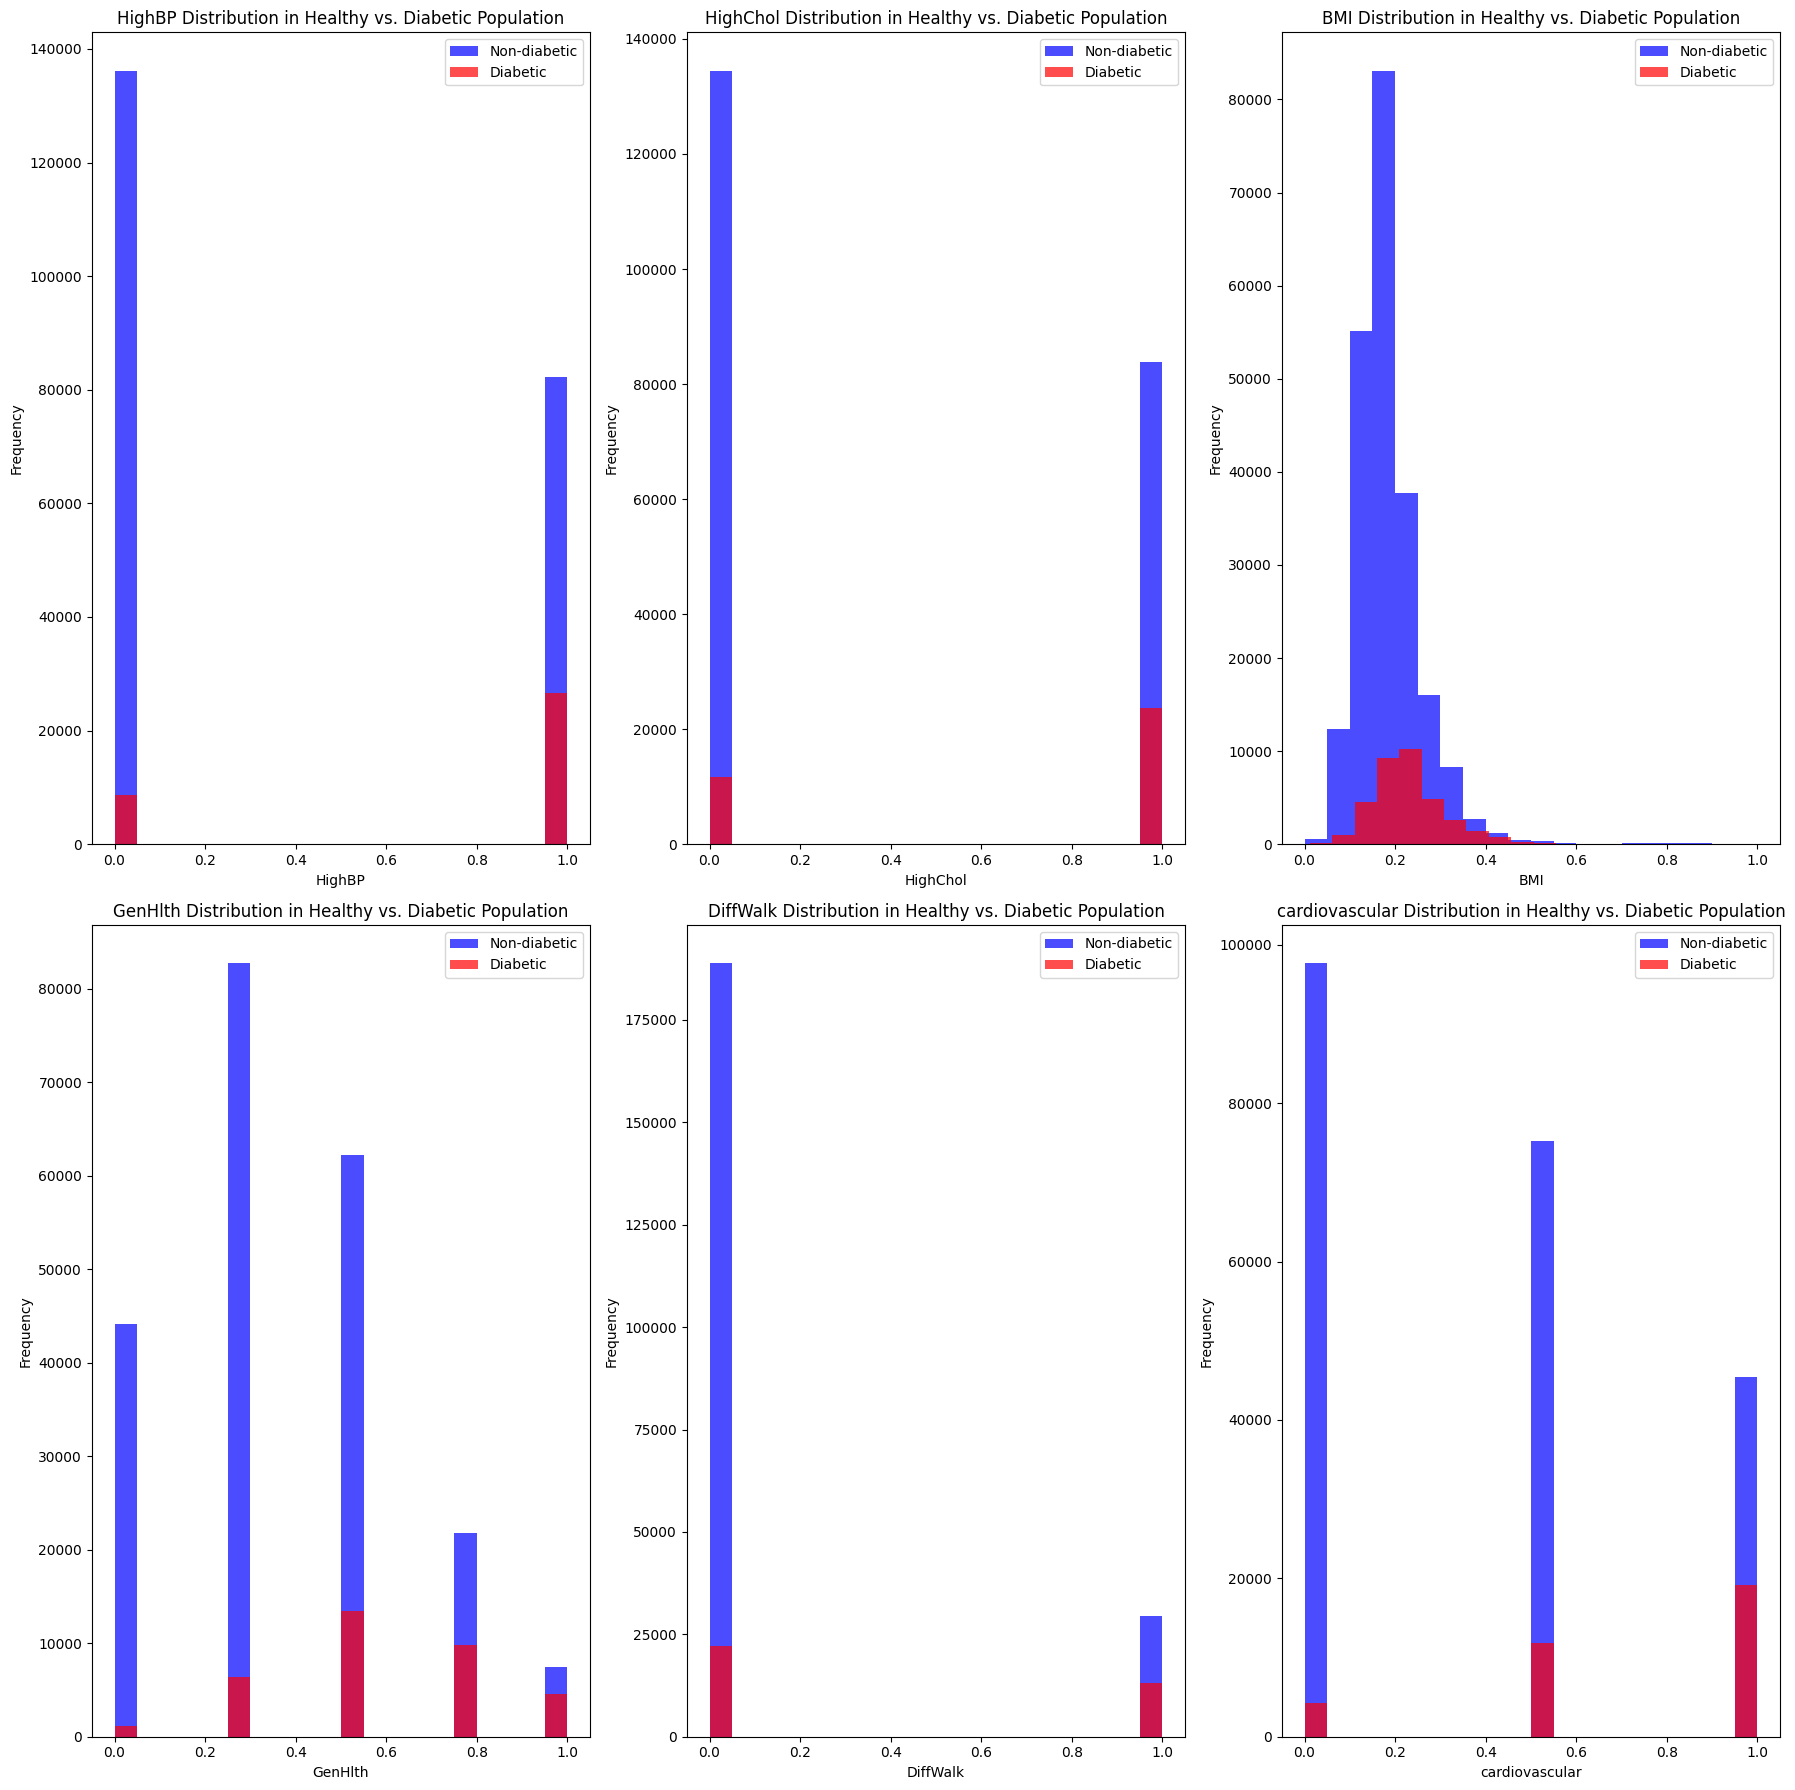

In [24]:
# Selection of features and target variables of interest
selected_columns.append('Diabetes_binary')
selected_df = joined_df.select(selected_columns)

# Collecting data to the local environment
data = selected_df.collect()

# Converting collected data to Python lists
high_bp = [row['HighBP'] for row in data]
high_chol = [row['HighChol'] for row in data]
bmi = [row['BMI'] for row in data]
gen_hlth = [row['GenHlth'] for row in data]
diff_walk = [row['DiffWalk'] for row in data]
cardiovascular = [row['cardiovascular'] for row in data]
diabetes_binary = [row['Diabetes_binary'] for row in data]

# Plot histograms of each characteristic separately, grouped by whether they have diabetes or not
features = {
    'HighBP': high_bp,
    'HighChol': high_chol,
    'BMI': bmi,
    'GenHlth': gen_hlth,
    'DiffWalk': diff_walk,
    'cardiovascular': cardiovascular
}

plt.figure(figsize=(18, 18))

for idx, (feature_name, feature_data) in enumerate(features.items()):
    # Grouping of data by presence or absence of diabetes
    diabetic_data = [feature_data[i] for i in range(len(diabetes_binary)) if diabetes_binary[i] == 1]
    non_diabetic_data = [feature_data[i] for i in range(len(diabetes_binary)) if diabetes_binary[i] == 0]
    
    # Plotting histograms for each feature
    plt.subplot(2, 3, idx + 1)
    plt.hist(non_diabetic_data, bins=20, alpha=0.7, label='Non-diabetic', color='b')
    plt.hist(diabetic_data, bins=20, alpha=0.7, label='Diabetic', color='r')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.title(f'{feature_name} Distribution in Healthy vs. Diabetic Population')
    plt.legend()

# Adjusting the layout and displaying the chart
plt.tight_layout()
plt.show()

#### 3.4 Chi-square Tests

In [ ]:
# Combine X and y into a single DataFrame
data_pyspark = X_pyspark.join(y_pyspark)

# Combine the features into a single vector column for ChiSquareTest
vector_assembler = VectorAssembler(inputCols=X_pyspark.columns, outputCol="features")
data_vector = vector_assembler.transform(data_pyspark)

# Run the Chi-square test on the features and the target variable
chi_square_result = ChiSquareTest.test(data_vector, "features", "Diabetes_binary")

# Show the results
chi_square_result.show(truncate=False)

## **5.Machine Learning Algorithms**

In [18]:
# Split the data into train and test sets
train_data, test_data = data_pyspark.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
# Assemble the features
assembler = VectorAssembler(inputCols=X_pyspark.columns, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

In [ ]:
# Logistic Regression
lr = LogisticRegression(labelCol="Diabetes_binary", featuresCol="features")

# Param grid for hyperparameter tuning
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-validation
cv_lr = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid_lr,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

# Fit model
lr_model = cv_lr.fit(train_data)


In [ ]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="Diabetes_binary", featuresCol="features")

paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 20]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()

cv_dt = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid_dt,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

dt_model = cv_dt.fit(train_data)


In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol="Diabetes_binary", featuresCol="features")

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

cv_rf = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid_rf,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

rf_model = cv_rf.fit(train_data)


In [ ]:
# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol="Diabetes_binary", featuresCol="features", maxIter=100)

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 20]) \
    .build()

cv_gbt = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid_gbt,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

gbt_model = cv_gbt.fit(train_data)


In [ ]:
# Support Vector Machine
svm = LinearSVC(labelCol="Diabetes_binary", featuresCol="features")

paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .build()

cv = CrossValidator(estimator=svm,
                    estimatorParamMaps=paramGrid,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

svm_model = cv.fit(train_data)


In [ ]:
# Naive Bayes Classifier
nb = NaiveBayes(labelCol="Diabetes_binary", featuresCol="features")

paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 1.5]) \
    .build()

cv_nb = CrossValidator(estimator=nb,
                    estimatorParamMaps=paramGrid_nb,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

nb_model = cv_nb.fit(train_data)


In [ ]:
# MLP classifier
mlp = MultilayerPerceptronClassifier(labelCol="Diabetes_binary", featuresCol="features", layers=layers, seed=1234)

paramGrid_mlp = ParamGridBuilder() \
    .addGrid(mlp.layers, [[len(X_pyspark.columns), 5, 4, 2], [len(X_pyspark.columns), 10, 5, 2]]) \
    .build()

cv_mlp = CrossValidator(estimator=mlp,
                    estimatorParamMaps=paramGrid_mlp,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

mlp_model = cv_mlp.fit(train_data)